<a href="https://colab.research.google.com/github/dr-song-summer-project/AI/blob/main/Clustering/K_Means_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**https://techblog-history-younghunjo1.tistory.com/114**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
clustering_num = 15
similarity_cmp = 'reviewRate'

In [ ]:
# 학습용 데이터셋 불러오기
import pandas as pd
document_df = pd.read_csv('/content/drive/My Drive/닥터송 여름 프로젝트/4. 대-스타 해결 2/09.(주)맘편한세상_데이터/unlabeled_data.csv')
# document_df.head()

document_df.drop(['encodedSenderId', 'encodedTargetId', 'DateTime'], axis=1, inplace=True)
document_df.head()

,reviewIndex,reviewContent,reviewRate,reviewType
0,0,돌보시다가 시간이 맞지않으셨는지 곧 그만두신다 하셨습니다. 일하시다 불만족스러우신...,1,recruitReview
1,1,자신감을 갖고 아기에게 다가간다면 거 좋을것같아요. 홧팅하세요~~,3,recruitReview
2,2,어리지만 아이의 의사표현이 확실해요\n 아이가 20-30대 시터를 좋아한다...,3,recruitReview
3,3,사정이 있어서 아쉽게도 함께하지 못했네요,3,recruitReview
4,4,전화인터뷰 때 그리고 저희집에 오신 첫 날에 정기적으로 오셨으면 좋겠다고 사전에 말...,1,recruitReview


In [ ]:
# 텍스트 단어들의 어근 원형을 추출하기 위해 함수 생성
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import nltk
import string
nltk.download('punkt')
nltk.download('wordnet')
# string.puncutaion에 문자열의 모든 구두점이 들어있음
# 이를 활용해서 Tokenize시킬 때 구두점들을 제외하기 위한 것
# ord('문자열') => 문자열의 ASCII코드를 반환해줌!
# dict(key, value)형태로 모든 구두점의 각 ASCII코드를 key값으로 넣어주자!
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

# 토큰화한 각 단어들의 원형들을 리스트로 담아서 반환
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]
# 텍스트를 Input으로 넣어서 토큰화시키고 토큰화된 단어들의 원형들을 리스트로 담아 반환
def LemNormalize(text):
    # .translate인자에 구두점 dict넣어주어서 구두점 삭제해준 상태로 토큰화시키기!
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

# Tf-idf 벡터화시키면서 cusotmized해준 토큰화+어근추출 방식 tokenizer인자에 넣어주기
# 벡터화시킬 Tf-idf 도구 옵션 추가해서 구축
# 1,2gram적용, 빈도수 0.05이하, 0.85이상의 빈도수 단어들 제거
tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize,
                            stop_words='english', ngram_range=(1,2),
                            min_df=0.05, max_df=0.85)
# fit_transform으로 위에서 구축한 도구로 텍스트 벡터화
ftr_vect = tfidf_vect.fit_transform(document_df['reviewContent'])
print(ftr_vect.shape)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(13283, 16)


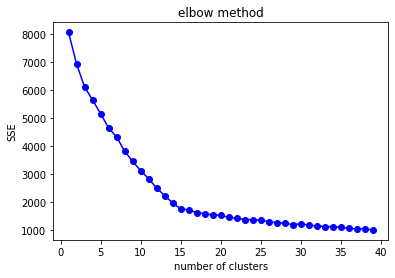

In [ ]:
def elbow(data, length):
    sse = [] # sum of squre error 오차제곱합
    for i in range(1, length):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(data)
        # SSE 값 저장
        sse.append(kmeans.inertia_)
    plt.plot(range(1, length), sse, 'bo-')
    plt.title("elbow method")
    plt.xlabel("number of clusters")
    plt.ylabel("SSE")
    plt.show()
elbow(ftr_vect, 40)

In [ ]:
# K-means로 clustering_num개 군집으로 문서 군집화시키기
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=clustering_num, max_iter=10000, random_state=42)
# 비지도 학습이니 feature로만 학습시키고 예측
cluster_label = kmeans.fit_predict(ftr_vect)

print(cluster_label)

# 군집화한 레이블값들을 document_df 에 추가하기
document_df['cluster_label'] = cluster_label
print(document_df.sort_values(by=['cluster_label']))
# document_df['reviewType']

[6 1 1 ... 0 8 2]
       reviewIndex  ... cluster_label
3608          3608  ...             0
7114          7114  ...             0
1282          1282  ...             0
3691          3691  ...             0
6101          6101  ...             0
...            ...  ...           ...
10133        10133  ...            14
6195          6195  ...            14
6198          6198  ...            14
10039        10039  ...            14
6641          6641  ...            14

[13283 rows x 5 columns]


In [ ]:
document_df.to_excel('clustering_result.xlsx', header=True, index=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'clustering result')

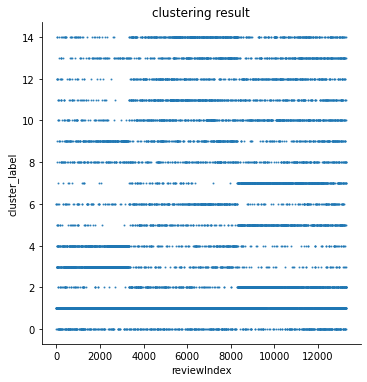

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

sb.lmplot('reviewIndex', 'cluster_label', data=document_df, fit_reg=False, scatter_kws={"s":1})

plt.title('clustering result')

In [ ]:
def get_cluster_details(cluster_model, cluster_data, feature_names,
                       cluster_num, top_n_features=10):
    cluster_details = {}
    # 각 클러스터 레이블별 feature들의 center값들 내림차순으로 정렬 후의 인덱스를 반환
    center_feature_idx = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    # 개별 클러스터 레이블별로 
    for cluster_num in range(cluster_num):
        # 개별 클러스터별 정보를 담을 empty dict할당
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # 각 feature별 center값들 정렬한 인덱스 중 상위 10개만 추출
        top_ftr_idx = center_feature_idx[cluster_num, :top_n_features]
        top_ftr = [feature_names[idx] for idx in top_ftr_idx]
        # top_ftr_idx를 활용해서 상위 10개 feature들의 center값들 반환
        # 반환하게 되면 array이기 떄문에 리스트로바꾸기
        top_ftr_val = cluster_model.cluster_centers_[cluster_num, top_ftr_idx].tolist()
        
        # cluster_details 딕셔너리에다가 개별 군집 정보 넣어주기
        cluster_details[cluster_num]['top_features'] = top_ftr
        cluster_details[cluster_num]['top_featrues_value'] = top_ftr_val
        # 해당 cluster_num으로 분류된 파일명(문서들) 넣어주기
        filenames = cluster_data[cluster_data['cluster_label']==cluster_num][similarity_cmp]
        # filenames가 df으로 반환되기 떄문에 값들만 출력해서 array->list로 변환
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['filenames'] = filenames
    
    return cluster_details

def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print(f"#####Cluster Num: {cluster_num}")
        print()
        print("상위 10개 feature단어들:\n", cluster_detail['top_features'])
        print()
        print(f"Cluster {cluster_num}으로 분류된 문서들:\n{cluster_detail['filenames'][:5]}")
        print('-'*20)

feature_names = tfidf_vect.get_feature_names()
cluster_details = get_cluster_details(cluster_model=kmeans,
                                     cluster_data=document_df,
                                     feature_names=feature_names,
                                     cluster_num=clustering_num,
                                     top_n_features=10)
print_cluster_details(cluster_details)

In [ ]:
# 시각화에 필요한 모듈 불러오기
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# df : 데이터셋
# cluster : 데이터셋에서 클러스터 결과 컬럼명
cluster_size = df.groupby(['cluster'])['id'].count()    # 'id' 대신 아무 컬럼 이름을 적어도 무방
print(cluster_size)
cluster_size.plot(kind = 'bar')

NameError: ignored

In [ ]:
# 클러스터링된 문서들 중에서 특정 문서를 하나 선택한 후 비슷한 문서 추출
from sklearn.metrics.pairwise import cosine_similarity
random_int = 1
hotel_idx = document_df[document_df['cluster_label']==0].index
print("호텔 카테고리로 클러스터링된 문서들의 인덱스:\n",hotel_idx)
print()
# 호텔 카테고리로 클러스터링 된 문서들의 인덱스 중 하나 선택해 비교 기준으로 삼을 문서 선정
comparison_doc = document_df.iloc[hotel_idx[random_int]][similarity_cmp]
print("##유사도 비교 기준 문서 이름:",comparison_doc,'##')
print()

# 위에서 추출한 호텔 카테고리로 클러스터링된 문서들의 인덱스 중 0번인덱스(비교기준문서)제외한
# 다른 문서들과의 유사도 측정
similarity = cosine_similarity(ftr_vect[hotel_idx[random_int]], ftr_vect[hotel_idx])
print(similarity)

Int64Index([10555,  1894,  1906,  6941, 10741,  1965,  4320,  2031,  2060,
             4280,
            ...
             7382, 12021, 10732, 12500,  7614, 12212, 12077, 11600, 11977,
            12869],
           dtype='int64', length=569)
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.  

Text(0.5, 1.0, '1')

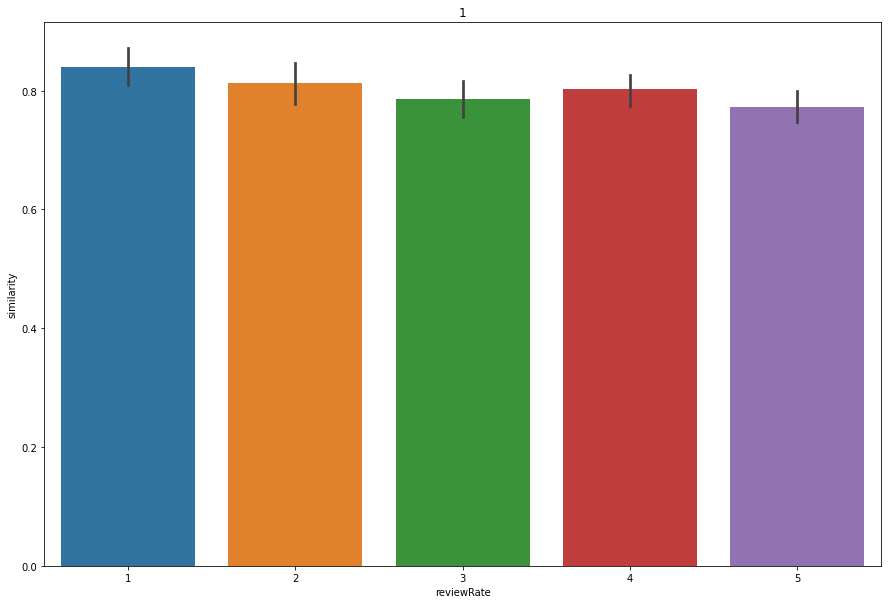

In [ ]:
# 비교기준 문서와 다른 문서들간의 유사도 살펴보기
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# array 내림차순으로 정렬한 후 인덱스 반환 [:,::-1] 모든행에 대해서 열을 내림차순으로!
sorted_idx = similarity.argsort()[:,::-1]
# 비교문서 당사자는 제외한 인덱스 추출
sorted_idx = sorted_idx[:, 1:]

# 유사도가 큰 순으로 hotel_idx(label=1인 즉, 호텔과관련된 내용의 문서이름들의 index들)에서 재 정렬 
# index로 넣으려면 1차원으로 reshape해주기!
hotel_sorted_idx = hotel_idx[sorted_idx.reshape(-1,)]
# 유사도 행렬값들을 유사도가 큰 순으로 재정렬(비교 문서 당사자는 제외)
hotel_sim_values = np.sort(similarity.reshape(-1,))[::-1]
hotel_sim_values = hotel_sim_values[1:]
# 이렇게 되면 비교문서와 가장 유사한 순으로 '해당문서의index-유사도값' 으로 동일한 위치가 매핑된 두 개의 array!
# 그래서 그대로 데이터프레임의 각 칼럼으로 넣어주기
print(hotel_sorted_idx)
print(hotel_sim_values)
print()
print("길이 비교", len(hotel_sorted_idx), len(hotel_sim_values))
print()
# 빈 데이터프레임 생성
hotel_sim_df = pd.DataFrame()
# hotel_sorted_idx 와 hotel_sim_values 매핑시킨 array임
hotel_sim_df[similarity_cmp] = document_df.iloc[hotel_sorted_idx][similarity_cmp]
hotel_sim_df['similarity'] = hotel_sim_values

plt.figure(figsize=(15,10))
sns.barplot(data=hotel_sim_df, x=similarity_cmp, y='similarity')
plt.title(comparison_doc)